# IEEE Fraud Detection Kaggle Competition
## LightGBM Baseline

In [7]:
%%bash

ls -l

cd ../data

ls -l

total 33912
-rw-r--r--  1 cchadha2  749149485  1976809 Aug  9 10:16 EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  1661687 Jul 29 22:42 IDs-EDA.ipynb
-rw-r--r--  1 cchadha2  749149485  2722094 Aug 19 00:18 V_engineering.ipynb
-rw-r--r--  1 cchadha2  749149485   222386 Aug  8 22:25 adverserial_validation.ipynb
-rw-r--r--  1 cchadha2  749149485   239908 Aug 12 23:40 lgb_<2_importance_removed_card1_count_encoded.ipynb
-rw-r--r--  1 cchadha2  749149485   683985 Aug 18 22:39 lgb_HasVfeats.ipynb
-rw-r--r--  1 cchadha2  749149485  5263263 Aug 18 22:39 lgb_HasVfeats2.ipynb
-rw-r--r--  1 cchadha2  749149485   614375 Aug 12 23:36 lgb_TransactionDay.ipynb
-rw-r--r--  1 cchadha2  749149485   869663 Aug 18 22:39 lgb_TransactionDay_and_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   582482 Aug 14 17:23 lgb_TransactionHour.ipynb
-rw-r--r--  1 cchadha2  749149485   238429 Aug 13 00:05 lgb_remove_D9.ipynb
-rw-r--r--  1 cchadha2  749149485   239532 Aug 19 00:17 lightgbm_baseline.ipynb
-rw-r--r--

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

In [9]:
pd.set_option('display.max_columns', 500)
num_folds = 5
SEED = 5000

# Load and prepare data

In [10]:
train_ids = pd.read_csv('../data/train_identity.csv.zip')
train_trans = pd.read_csv('../data/train_transaction.csv.zip')

test_ids = pd.read_csv('../data/test_identity.csv.zip')
test_trans = pd.read_csv('../data/test_transaction.csv.zip')

train = pd.merge(train_trans, train_ids, on='TransactionID', how='outer')
test = pd.merge(test_trans, test_ids, on='TransactionID', how='outer')

train.to_csv('../output/merged_train.csv', index=False)
test.to_csv('../output/merged_test.csv', index=False)

In [11]:
train = pd.read_csv('../output/merged_train.csv')
test = pd.read_csv('../output/merged_test.csv')
sub_df = pd.read_csv('../data/sample_submission.csv.zip')

In [12]:
train.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0

In [13]:
print(train.shape)

(590540, 434)


In [14]:
print(test.shape)

(506691, 433)


In [15]:
# Lightgbm parameters from https://www.kaggle.com/vincentlugat/ieee-lgb-bayesian-opt
params = {
        'bagging_fraction': 0.8999999999997461,
        'feature_fraction': 0.8999999999999121,
        'max_depth': int(50.0),
        'min_child_weight': 0.0029805017044362268,
        'min_data_in_leaf': int(20.0),
        'num_leaves': int(381.85354295079446),
        'reg_alpha': 1.0,
        'reg_lambda': 2.0,
        'objective': 'binary',
        'save_binary': True,
        'seed': SEED,
        'feature_fraction_seed': SEED,
        'bagging_seed': SEED,
        'drop_seed': SEED,
        'data_random_seed': SEED,
        'boosting_type': 'gbdt',
        'verbose': 1,
        'is_unbalance': False,
        'boost_from_average': True,
        'metric':'auc'
    }

early_rounds = 50
num_iterations = 200

In [16]:
categorical_features=['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
                      'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'M1',
                      'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
                      'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15',
                      'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
                      'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
                      'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36',
                      'id_37', 'id_38']

In [17]:
for feature in categorical_features:
    train[feature] = train[feature].astype('category')
    test[feature] = test[feature].astype('category')

# Splitting into train, val, and test

In [18]:
# Split train into features and target
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']

In [20]:
val_indices = np.load('../output/val_indices.npy')

In [21]:
val_indices

array([  5949,  10454,  12753, ..., 590520, 590526, 590529])

In [22]:
X_val = X.iloc[val_indices, :]
y_val = y.iloc[val_indices]

In [23]:
X_train = X.drop(val_indices)
y_train = y.drop(val_indices)

In [24]:
y_val.value_counts()

0    6839
1     332
Name: isFraud, dtype: int64

In [25]:
X_train.shape

(583369, 431)

In [26]:
X_val.shape

(7171, 431)

In [27]:
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)

# Train LightGBM

In [28]:
# Create arrays for oof predictions and sub predictions
val_preds = np.zeros(len(X_val))
sub_preds = np.zeros(len(sub_df))

In [29]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [30]:
clf = lgb.train(params, trn_data, num_iterations, valid_sets=[trn_data, val_data], verbose_eval=1,
                early_stopping_rounds=early_rounds)

/Users/cchadha2/anaconda3/envs/eda/lib/python3.7/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	training's auc: 0.902079	valid_1's auc: 0.850166
Training until validation scores don't improve for 50 rounds.
[2]	training's auc: 0.917741	valid_1's auc: 0.885333
[3]	training's auc: 0.92699	valid_1's auc: 0.89279
[4]	training's auc: 0.935052	valid_1's auc: 0.899016
[5]	training's auc: 0.940125	valid_1's auc: 0.908861
[6]	training's auc: 0.943037	valid_1's auc: 0.915306
[7]	training's auc: 0.946216	valid_1's auc: 0.921322
[8]	training's auc: 0.949643	valid_1's auc: 0.923748
[9]	training's auc: 0.952125	valid_1's auc: 0.926524
[10]	training's auc: 0.954439	valid_1's auc: 0.928669
[11]	training's auc: 0.956949	valid_1's auc: 0.930336
[12]	training's auc: 0.960102	valid_1's auc: 0.933922
[13]	training's auc: 0.962317	valid_1's auc: 0.936369
[14]	training's auc: 0.965747	valid_1's auc: 0.941263
[15]	training's auc: 0.967362	valid_1's auc: 0.940105
[16]	training's auc: 0.96943	valid_1's auc: 0.942835
[17]	training's auc: 0.971443	valid_1's auc: 0.945955
[18]	training's auc: 0.972826	va

[152]	training's auc: 0.999863	valid_1's auc: 0.979644
[153]	training's auc: 0.999868	valid_1's auc: 0.979717
[154]	training's auc: 0.999874	valid_1's auc: 0.979734
[155]	training's auc: 0.999878	valid_1's auc: 0.979813
[156]	training's auc: 0.999883	valid_1's auc: 0.979813
[157]	training's auc: 0.999887	valid_1's auc: 0.980004
[158]	training's auc: 0.999889	valid_1's auc: 0.980035
[159]	training's auc: 0.999893	valid_1's auc: 0.980127
[160]	training's auc: 0.999895	valid_1's auc: 0.980288
[161]	training's auc: 0.999898	valid_1's auc: 0.980365
[162]	training's auc: 0.999901	valid_1's auc: 0.980387
[163]	training's auc: 0.999905	valid_1's auc: 0.980401
[164]	training's auc: 0.999908	valid_1's auc: 0.980453
[165]	training's auc: 0.999911	valid_1's auc: 0.980437
[166]	training's auc: 0.999914	valid_1's auc: 0.980453
[167]	training's auc: 0.999916	valid_1's auc: 0.980582
[168]	training's auc: 0.999919	valid_1's auc: 0.980795
[169]	training's auc: 0.999921	valid_1's auc: 0.980844
[170]	trai

# Predict on test sets

In [31]:
sub_preds = clf.predict(X_test, num_iteration=clf.best_iteration)
val_preds = clf.predict(X_val, num_iteration=clf.best_iteration)

In [32]:
sub_preds

array([4.80804824e-05, 4.08115312e-04, 7.03201166e-05, ...,
       5.11824947e-04, 4.16457965e-05, 2.10097114e-04])

In [33]:
print('AUROC on validation set: {}'.format(roc_auc_score(y_val.values, val_preds)))

AUROC on validation set: 0.9817074996873002


# Bootstrapping

In [34]:
# Bootstrapping AUROC
n_bootstraps = 10000
bootstrapped_scores = []

np.random.seed(SEED)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(0, len(val_preds) - 1, len(val_preds))
    if len(np.unique(y_val.values[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_val.values[indices], val_preds[indices])
    bootstrapped_scores.append(score)

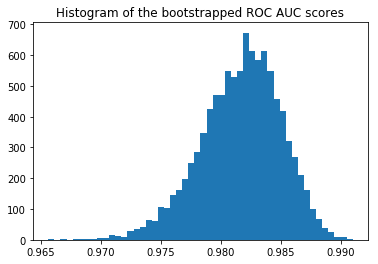

In [35]:
plt.figure()
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

In [36]:
sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 90% confidence interval
# You can change the bounds percentiles to 0.025 and 0.975 to get
# a 95% confidence interval instead.
confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

Confidence interval for the score: [0.976 - 0.987]


In [37]:
sorted_scores.mean()

0.9816605429125915

In [38]:
sorted_scores.std()

0.0033420229742594128

# Save submission predictions

In [39]:
sub_df['isFraud'] = sub_preds
sub_df.to_csv('submission.csv', index=False)

# Feature importances

In [40]:
# Concatenate fold importances into feature importance dataframe
feature_importance_df = pd.DataFrame()
feature_importance_df["feature"] = X_train.columns.tolist()
feature_importance_df["importance"] = clf.feature_importance()

In [41]:
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [42]:
feature_importance_df.head()

,feature,importance
2,card1,7948
0,TransactionAmt,6099
8,addr1,3720
10,dist1,2994
3,card2,2285


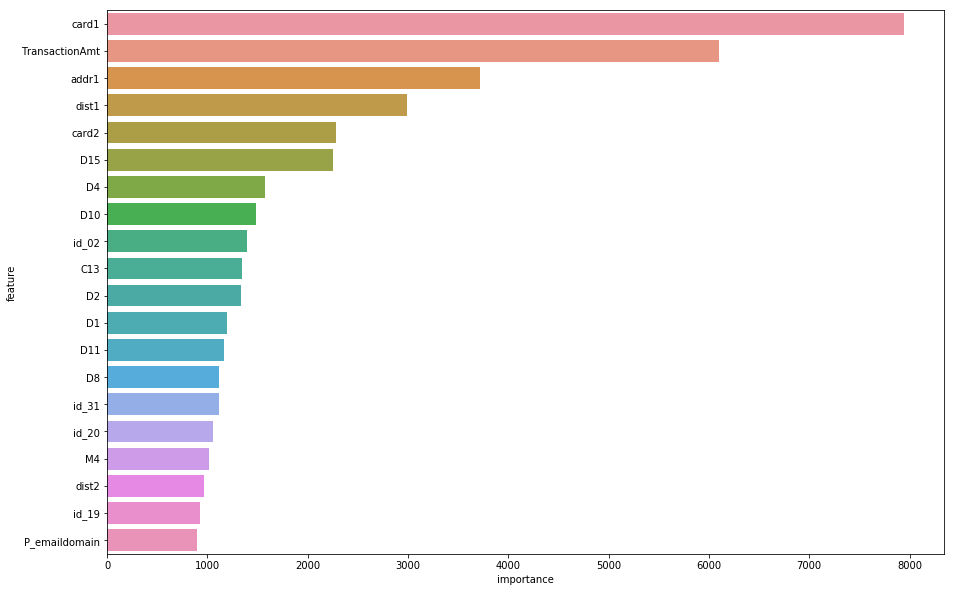

In [43]:
plt.figure(figsize=(15,10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))

In [44]:
# Save average feature importances
feature_importance_df.to_csv('lightgbm_importance.csv', index=False)